# Capstone Project
## OTHER EARTHS
Exoplanet-star Classifier


# DATA PREPROCESSING



In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import os
import boto3
import sagemaker
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
import torch
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
from random import sample 


## Reading Data

In [3]:
train_csv_path = "data/exoTrain.csv"
test_csv_path = "data/exoTest.csv"

train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)


## Data Exploration and Visualization

In [4]:
train_csv.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


print("Data dimensions:\nTrain:\t",train_csv.shape,"\nTest:\t", test_csv.shape)

In [5]:
print("Labels:\t",train_csv.LABEL.unique())

Labels:	 [2 1]


Here 2 represents an exoplanet-star and 1 represents that it is not an exoplanet-star.

The 3197 columns other than 'LABEL' denote the time-series of flux values obtained by the satellite for each star.


#### Checking for missing values


In [6]:
train_csv.isna().sum().sum(),test_csv.isna().sum().sum()

(0, 0)

No missing values in the dataset

#### Data Imbalance

In [7]:
pos_labels,neg_labels = train_csv.LABEL.value_counts()
print("Positives(2):",pos_labels,"\nNegatives(1):",neg_labels)
positive_idx = np.where(train_csv.LABEL==2)[0]
print(positive_idx)


Positives(2): 5050 
Negatives(1): 37
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


As the data is sorted according to labels and also highly imbalanced, shuffling and weightd sampling while loading batches for traininng is essential.

In [8]:
negative_idx = [i for i in range(37,len(train_csv))]
len(negative_idx)

5050

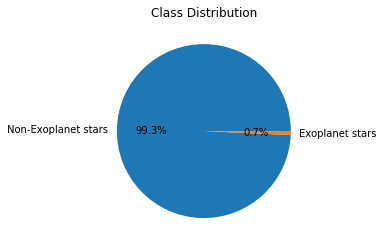

In [9]:
plt.pie([pos_labels,neg_labels],labels=["Non-Exoplanet stars","Exoplanet stars"],autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

#### Flux vs Time curves for some Exoplanet stars

In [10]:
rand = np.random.permutation(positive_idx)[:5]
rand_data=train_csv.iloc[rand,1:].reset_index()
rand_data


,index,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
1,33,43.07,46.73,29.43,9.75,6.54,-3.76,-31.48,-46.94,-40.78,...,6.99,5.75,23.18,15.08,18.09,13.40,15.78,18.18,51.21,9.71
2,36,26.24,42.32,28.34,24.81,49.39,47.57,41.52,51.80,25.50,...,-7.53,-35.72,-14.32,-29.21,-30.61,8.49,4.75,6.59,-7.03,24.41
3,30,-472.50,-384.09,-330.42,-273.41,-185.02,-115.64,-141.86,-16.23,77.80,...,-3408.88,-3425.92,-3465.59,-3422.95,-3398.83,-3410.42,-3393.58,-3407.78,-3391.56,-3397.03
4,19,560.19,262.94,189.94,185.12,210.38,104.19,289.56,172.06,81.75,...,106.00,-7.94,-7.94,-7.94,52.31,-165.00,7.38,-61.56,-44.75,104.50


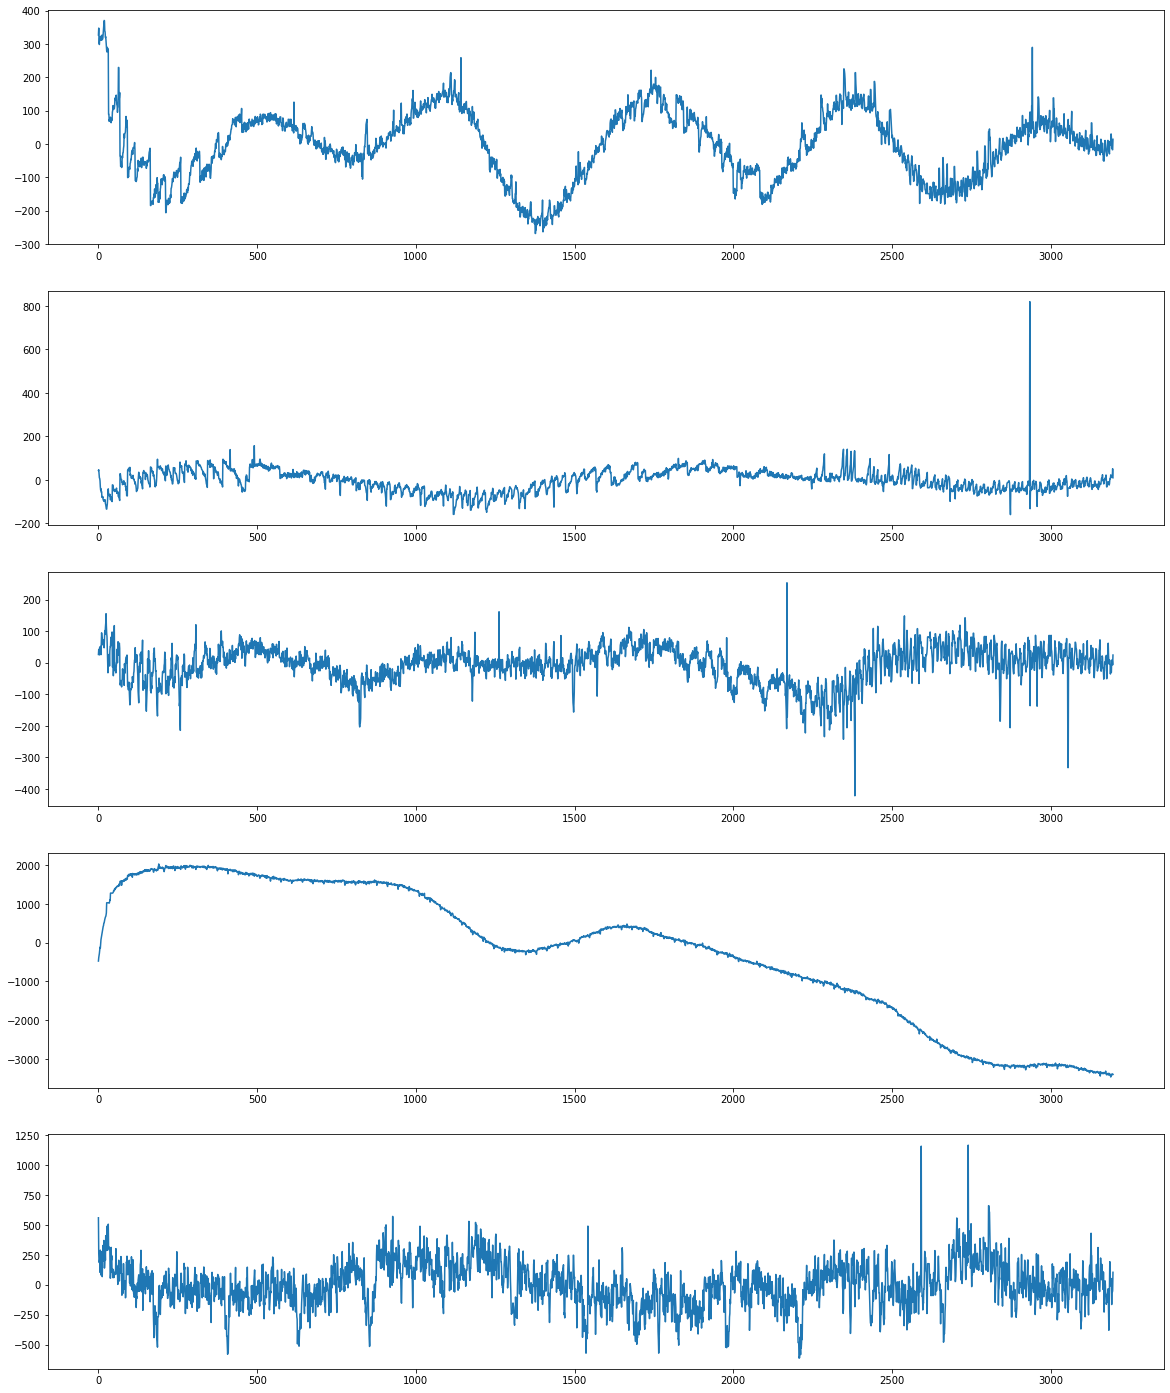

In [11]:
fig,ax = plt.subplots(5,figsize=(20,25))
for i in range(0,5):
    ax[i].plot(range(0,3197),rand_data.iloc[i,1:])

#### Flux vs Time curves for some Non-exoplanet stars

In [12]:
rand = np.random.permutation(negative_idx)[:5]
rand_data=train_csv.iloc[rand,1:].reset_index()
rand_data


,index,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,719,11.47,9.03,12.46,9.85,11.82,2.86,10.10,5.33,2.36,...,11.60,13.99,6.79,4.94,17.11,-8.61,-7.40,-8.69,-11.87,-11.82
1,4234,-85.60,-63.64,-73.80,-79.62,-70.22,-63.15,-58.66,-50.16,-53.03,...,-6.69,-8.33,-12.31,-4.97,-5.59,-3.09,-13.50,-7.12,-10.66,-13.83
2,3821,522.18,60.68,-69.06,715.42,146.79,221.17,272.14,270.71,-52.06,...,-60.73,-518.96,353.50,902.60,-833.77,-0.50,99.40,-1078.89,571.10,268.08
3,4968,-291.34,-291.58,-340.92,-352.79,-307.01,-291.22,-226.26,-189.73,-174.20,...,-61.01,-93.54,-128.36,-75.39,-67.45,-56.51,13.14,-19.93,-10.90,24.52
4,379,-6.92,-14.13,-6.15,-1.08,-0.68,-10.76,-15.65,-10.81,-10.32,...,-7.96,-0.48,-4.02,-0.93,-3.46,-3.32,20.60,20.78,8.03,11.03


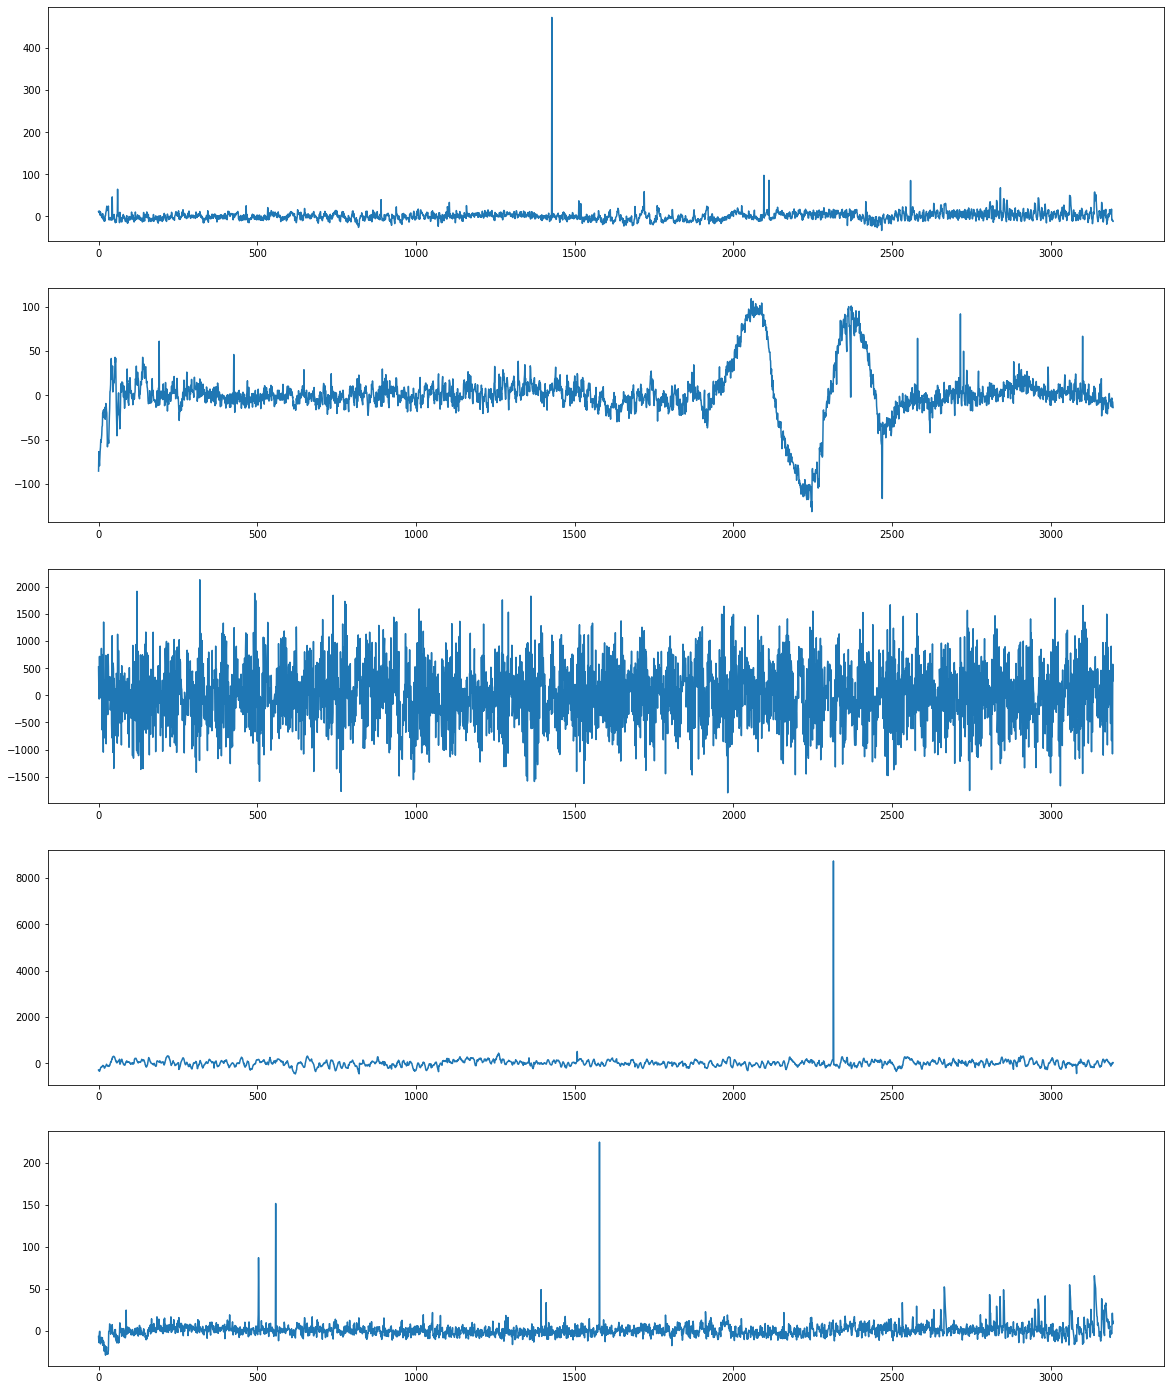

In [13]:
fig,ax = plt.subplots(5,figsize=(20,25))
for i in range(0,5):
    ax[i].plot(range(0,3197),rand_data.iloc[i,1:])

As it is evident from the plots that the data has high frequency noise which might hamper the classification, therefore smoothening of data is essential.

## Feature Engineering

#### Smoothening the data with uniform filter

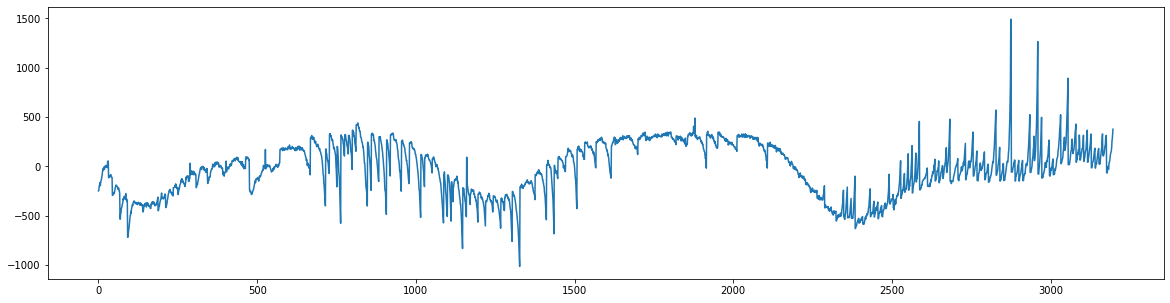

In [14]:
#Let's plot the 35th star to check the effect of uniform filter
# fig,ax=plt.plot(1,)
plt.figure(figsize=(20,5))
plt.plot(range(0,3197),train_csv.iloc[34,1:])
plt.show()

#### Avg over 50, 100, 150 and 200 timestamps

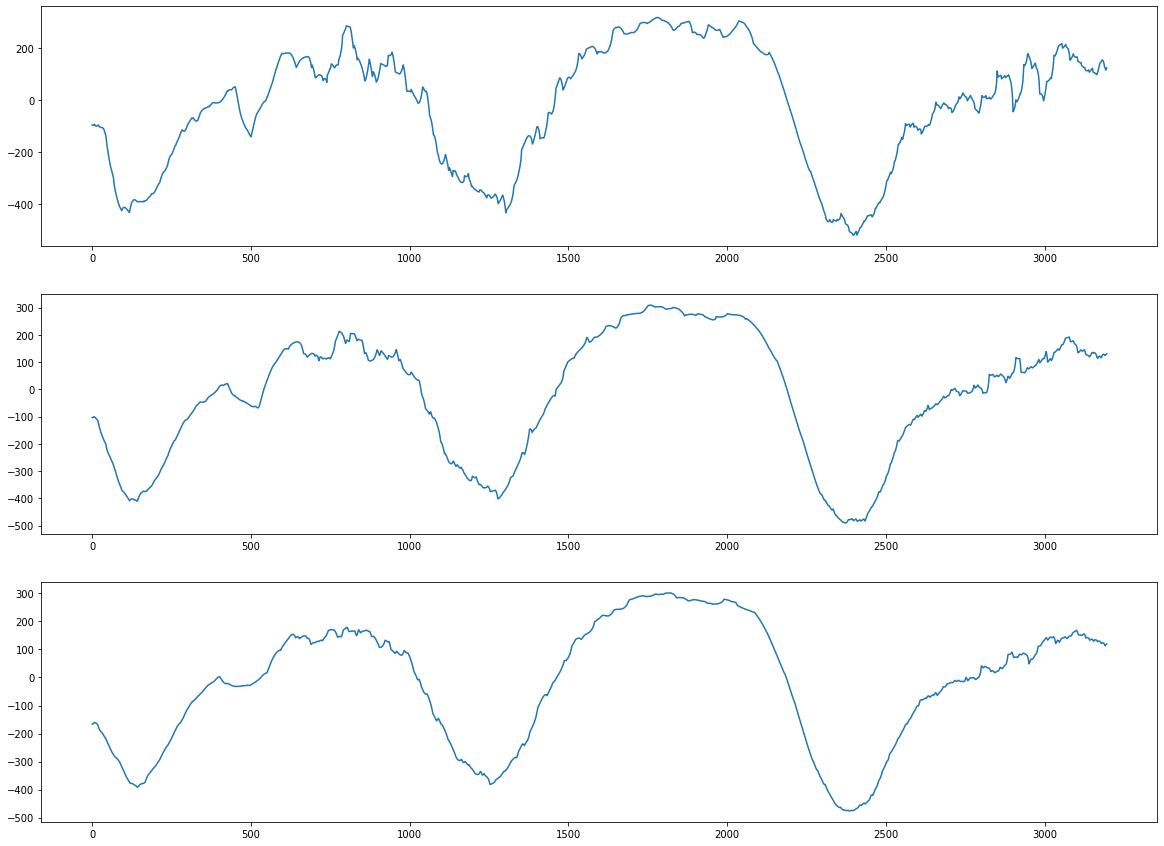

In [15]:
sizes = [50,100,150]
fig,ax = plt.subplots(3,figsize=(20,15))
for i,size in enumerate(sizes):
    ax[i].plot(range(0,3197),uniform_filter1d(train_csv.iloc[34,1:],size=size))

From the observations 100 timestamps seems an appropriate size for the filter

In [16]:
##applying uniform fiter to the train and test set 
train_x = uniform_filter1d(train_csv.iloc[:,1:],axis=1,size=100)
test_x = uniform_filter1d(test_csv.iloc[:,1:],axis=1,size=100)

#converting target 2->1 and 1->0
train_y = (train_csv.LABEL-1)
test_y = (test_csv.LABEL-1)
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((5087, 3197), (5087,), (570, 3197), (570,))

## Creating CSV file

In [17]:
train = pd.concat([pd.DataFrame(train_x),pd.DataFrame(train_y)],axis=1)
test = pd.concat([pd.DataFrame(test_x),pd.DataFrame(test_y)],axis=1)
train.shape,test.shape

((5087, 3198), (570, 3198))

In [18]:
data_dir = "data"

train.to_csv(os.path.join(data_dir, "train.csv"), header=False, index=False)
test.to_csv(os.path.join(data_dir, "test.csv"), header=False, index=False)